In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Approximate Max-Cut using a Divide-and-Conquer Implementation of QAOA
## Lab 2: Illustrating one level of the Divide-and-Conquer QAOA


## 2.1 Introduction

Having seen a preview of the divide-and-conquer QAOA in [Lab 1](1_Overview-Max-Cut-with-QAOA.ipynb), we are ready to dive into the details of the algorithm here. In this lab, we will introduce the main steps of the divide-and-conquer QAOA algorithm through an example graph that requires only one divide-and-conquer iteration. This will prepare us for Lab 3 in which we will iterate these steps recursively and in parallel to handle much larger problem instances.  

**Relationship to circuit cutting:** From one point of view, the divide-and-conquer QAOA divides a graph into smaller graphs, and the max cut problems on those subgraphs are solved. Later these subgraph solutions are merged together for a max cut approximation of the parent graph. We see this viewpoint in work by [Esposito and Danzig](https://arxiv.org/abs/2406.17383), [Guerreschi](https://arxiv.org/abs/2101.07813), [Li et al.](https://arxiv.org/abs/2311.02302), [Liers et al.](https://onlinelibrary.wiley.com/doi/abs/10.1002/3527603794.ch4),  [Ponce et al.](https://arxiv.org/abs/2306.00494), [Yue et al.](https://arxiv.org/pdf/2310.05062.pdf), and [Zhao et al](https://arxiv.org/abs/2205.11762).  Another way of positioning the divide-and-conquer QAOA is as a circuit cutting protocol.  *Circuit cutting* is a technique of dividing a quantum circuit into subcircuits with fewer gates and qubits. After running these circuits, post-processing stitches the results together to get an approximation of the execution of the original circuit.  This is the viewpoint presented in the work of [Cattelan and Yarkoni](https://arxiv.org/abs/2304.03037) and of [Bechtold et al](https://iopscience.iop.org/article/10.1088/2058-9565/acf59c). As you complete the lab, we encourage you to think about how these two viewpoints are related.

In this lab, we implement the divide-and-conquer QAOA in three steps:
1. **Divide:**  The divide-and-conquer algorithm divides the initial graph into small enough subgraphs, recursively if necessary.
2. **Conquer:** QAOA is executed to find max-cut approximations of the smaller subgraphs, in parallel when possible.
3. **Merge:** To stitch together the subgraph solutions into a solution of their parent graph, we consider the border subgraph generated by the edges between the subgraphs.  We define a new graph based on a different vertex set, which we will call the merger graph. This graph captures the interactions between border vertices. Finally, to merge the subgraph solutions together for an approximately optimal solution to the larger graph, we employ QAOA to the merger graph invoking a new cost function.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/images/divide-and-conquer-steps.png?raw=true)



### 2.1.1 Overview of the notebook

This notebook is structured as follows:

* **2.2 Divide**
    * Estimate the max cut value of a moderately sized example graph (called `sampleGraph2` in this notebook) using classical heuristics
    * Partition `sampleGraph2` into smaller subgraphs
* **2.3 Conquer**
    * Estimate the max cut value of each of the subgraphs in the partition using a routine QAOA implementation with CUDA-Q's `vqe` function
* **2.4 Merge**
    * Apply a brute-force computation to stitch together the subgraph solutions into an approximate max cut of `sampleGraph2`
    * Define a new graph, `mergerGraph`, whose vertices represent each of the subgraphs in the partition and define a new cost function that codes the optimization problem for optimally stitching together subgraph solutions into a cut of `sampleGraph2`
    * Apply QAOA to the `mergerGraph` optimization problem and use the result to merge the subgraph solutions into an approximate max cut solution of the `sampleGraph2`
* **2.5 Enable Distributed Quantum Computing**
    * Write a Python script to execute the conquer stage of one level of the divide-and-conquer algorithm in parallel

Learning objectives:
* Implement a one-level divide-and-conquer QAOA for Max Cut using CUDA-Q
* Apply QAOA to find an approximate solution to Quadratic Unconstrained Binary Optimization problems
* Select from different target devices to execute quantum circuits
* Adapt the CUDA Quantum code to run in parallel on multiple GPUs or multiple QPUs



### 2.1.2 Reusable code from Lab 1
Before we begin, let's grab the relevant code from Lab 1 that we will repurpose in this lab. As you execute these cells, take a moment to read through them to recognize their purpose and logic.

In [2]:
# Necessary packages
import networkx as nx
from networkx import algorithms
from networkx.algorithms import community
import cudaq
from cudaq import spin
from cudaq.qis import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List


In [3]:
# Define a function to generate the Hamiltonian for a max cut problem using the graph G

def hamiltonian_max_cut(sources : List[int], targets : List[int]):
    """Hamiltonian for finding the max cut for the graph  with edges defined by the pairs generated by source and target edges

    Parameters
    ----------
    sources: List[int]
        list of the source vertices for edges in the graph
    targets: List[int]
        list of the target vertices for the edges in the graph

    Returns
    -------
    cudaq.SpinOperator
        Hamiltonian for finding the max cut of the graph defined by the given edges
    """
    hamiltonian = 0
    # Since our vertices may not be a list from 0 to n, or may not even be integers,

    for i in range(len(sources)):
        # Add a term to the Hamiltonian for the edge (u,v)
        qubitu = sources[i]
        qubitv = targets[i]
        hamiltonian += 0.5*(spin.z(qubitu)*spin.z(qubitv)-spin.i(qubitu)*spin.i(qubitv))

    return hamiltonian

# Problem Kernel

@cudaq.kernel
def qaoaProblem(qubit_0 : cudaq.qubit, qubit_1 : cudaq.qubit, alpha : float):
    """Build the QAOA gate sequence between two qubits that represent an edge of the graph
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit representing the first vertex of an edge
    qubit_1: cudaq.qubit
        Qubit representing the second vertex of an edge
    alpha: float
        Free variable

    """
    x.ctrl(qubit_0, qubit_1)
    rz(2.0*alpha, qubit_1)
    x.ctrl(qubit_0, qubit_1)

# Mixer Kernel
@cudaq.kernel
def qaoaMixer(qubit_0 : cudaq.qubit, beta : float):
    """Build the QAOA gate sequence that is applied to each qubit in the mixer portion of the circuit
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit
    beta: float
        Free variable

    """
    rx(2.0*beta, qubit_0)


# We now define the kernel_qaoa function which will be the QAOA circuit for our graph
# Since the QAOA circuit for max cut depends on the structure of the graph,
# we'll feed in global concrete variable values into the kernel_qaoa function for the qubit_count, layer_count, edges_src, edges_tgt.
# The types for these variables are restricted to Quake Values (e.g. qubit, int, List[int], ...)
# The thetas plaeholder will be our free parameters (the alphas and betas in the circuit diagrams depicted above)
@cudaq.kernel
def kernel_qaoa(qubit_count :int, layer_count: int, edges_src: List[int], edges_tgt: List[int], thetas : List[float]):
    """Build the QAOA circuit for max cut of the graph with given edges and nodes
    Parameters
    ----------
    qubit_count: int
        Number of qubits in the circuit, which is the same as the number of nodes in our graph
    layer_count : int
        Number of layers in the QAOA kernel
    edges_src: List[int]
        List of the first (source) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    edges_tgt: List[int]
        List of the second (target) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    thetas: List[float]
        Free variables to be optimized

    """
    # Let's allocate the qubits
    qreg = cudaq.qvector(qubit_count)

    # And then place the qubits in superposition
    h(qreg)

    # Each layer has two components: the problem kernel and the mixer
    for i in range(layer_count):
        # Add the problem kernel to each layer
        for edge in range(len(edges_src)):
            qubitu = edges_src[edge]
            qubitv = edges_tgt[edge]
            qaoaProblem(qreg[qubitu], qreg[qubitv], thetas[i])
        # Add the mixer kernel to each layer
        for j in range(qubit_count):
            qaoaMixer(qreg[j],thetas[i+layer_count])

In [4]:
def find_optimal_parameters(G, layer_count, seed):
    """Function for finding the optimal parameters of QAOA for the max cut of a graph
    Parameters
    ----------
    G: networkX graph
        Problem graph whose max cut we aim to find
    layer_count : int
        Number of layers in the QAOA circuit
    seed : int
        Random seed for reproducibility of results

    Returns
    -------
    list[float]
        Optimal parameters for the QAOA applied to the given graph G
    """
    parameter_count: int = 2 * layer_count

    # Problem parameters
    nodes = sorted(list(nx.nodes(G)))
    qubit_src = []
    qubit_tgt = []
    for u, v in nx.edges(G):
        # We can use the index() command to read out the qubits associated with the vertex u and v.
        qubit_src.append(nodes.index(u))
        qubit_tgt.append(nodes.index(v))
    # The number of qubits we'll need is the same as the number of vertices in our graph
    qubit_count : int = len(nodes)
    # Each layer of the QAOA kernel contains 2 parameters
    parameter_count : int = 2*layer_count

    # Specify the optimizer and its initial parameters.
    optimizer = cudaq.optimizers.COBYLA()
    np.random.seed(seed)
    optimizer.initial_parameters = np.random.uniform(-np.pi, np.pi,
                                                     parameter_count)

    # Pass the kernel, spin operator, and optimizer to `cudaq.vqe`.
    optimal_expectation, optimal_parameters = cudaq.vqe(
        kernel=kernel_qaoa,
        spin_operator=hamiltonian_max_cut(qubit_src, qubit_tgt),
        argument_mapper=lambda parameter_vector: (qubit_count, layer_count, qubit_src, qubit_tgt, parameter_vector),
        optimizer=optimizer,
        parameter_count=parameter_count)

    return optimal_parameters

In [5]:
def qaoa_for_graph(G, layer_count, shots, seed):
    """Function for finding the max cut of a graph using QAOA

    Parameters
    ----------
    G: networkX graph
        Problem graph whose max cut we aim to find
    layer_count : int
        Number of layers in the QAOA circuit
    shots : int
        Number of shots in the sampling subroutine
    seed : int
        Random seed for reproducibility of results

    Returns
    -------
    str
        Binary string representing the max cut coloring of the vertinces of the graph
    """


    parameter_count: int = 2 * layer_count

    # Problem parameters
    nodes = sorted(list(nx.nodes(G)))
    qubit_src = []
    qubit_tgt = []
    for u, v in nx.edges(G):
        # We can use the index() command to read out the qubits associated with the vertex u and v.
        qubit_src.append(nodes.index(u))
        qubit_tgt.append(nodes.index(v))
    # The number of qubits we'll need is the same as the number of vertices in our graph
    qubit_count : int = len(nodes)
    # Each layer of the QAOA kernel contains 2 parameters
    parameter_count : int = 2*layer_count

    optimal_parameters = find_optimal_parameters(G, layer_count, seed)

    # Print the optimized parameters
    print("Optimal parameters = ", optimal_parameters)

    # Sample the circuit
    counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, qubit_src, qubit_tgt, optimal_parameters, shots_count=shots)
    print('most_probable outcome = ',counts.most_probable())
    results = str(counts.most_probable())
    return results

## 2.2 Defining a graph

The goal of this lab is to use divide-and-conquer QAOA to find an approximate max cut of the graph defined and plotted below. We chose a moderately sized random graph for this demonstration.  In Lab 3, we'll look at an even larger graph.

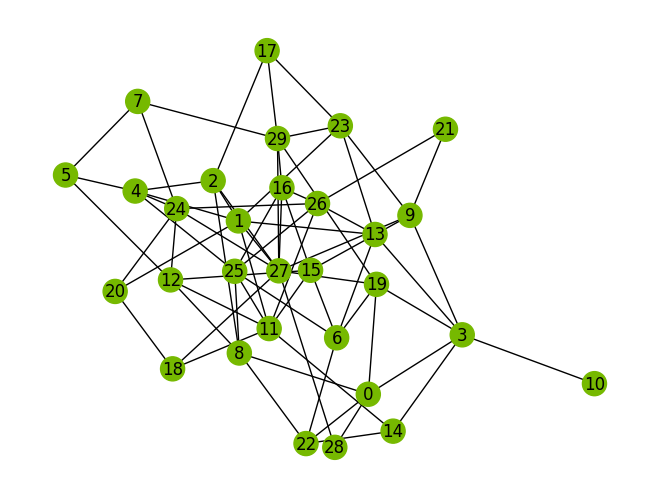

In [6]:

#random graph parameters
n = 30  # numnber of nodes
# Once you've completed the lab, try increasing the number of nodes to 40
m = 70  # number of edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
sampleGraph2 = nx.gnm_random_graph(n, m, seed=seed)

# Set color variables for plotting
gray ='#8C8C8C'
green ='#76B900'

# Set the position of the nodes so that the graph is easily recognizable each time it's plotted
pos = nx.spring_layout(sampleGraph2, seed=12345)

# Plot example graph for which we will be trying to compute the max cut
color_map = [green]* sampleGraph2.number_of_nodes()
nx.draw(sampleGraph2, with_labels=True, pos = pos, node_color=color_map)

#plt.savefig('sampleGraph2.png')
plt.show()




We will call this graph `sampleGraph2` for the purposes of this exposition. This graph has so many vertices and edges that the circuit depth and width of the QAOA max cut circuit would likely be too large to run and/or simulate on most systems. In particular we would need 30 qubits for the max cut QAOA circuit of this graph. Therefore, `sampleGraph2` is a good candidate to experiment with the divide-and-conquer QAOA. We'll see that by dividing this graph into smaller graphs, we will be able to replace a QAOA circuit requiring 30 qubits with a handful of circuits of 8 qubits or fewer!

For our initial experiment of the divide-and-conquer QAOA, it would be good to have a sense of the actual max cut solution of `sampleGraph2`. Therefore, we chose `sampleGraph2` to be small enough that we can use a classical greedy algorithm (NetworkX `one_exchange`) to approximate the max cut solution. To read more about the `one_exchange` algorithm, see the [NetworkX documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.maxcut.one_exchange.html).  Note that there are other classical heuristics that can handle much larger graphs and that there are exact polynomial-time algorithms for restricted graph classes (for a survey and comparison of these, check out [this paper](https://dl.acm.org/doi/full/10.1145/3609426?casa_token=ZrJI6LlgDHAAAAAA%3AhuO3qe07eG0kXdWEvKY4Xv7kIDpWXpe5SAr-zB9KVzOe3nHnTSE-zqqwbbhN_syDdfrASv8xGmv29sk)). However, the greedy algorithm is sufficient for our demonstration.

In [7]:
# classical heuristic approximation to the Max Cut of the initial graph using greedy modularity maximization
random_seed = np.random.randint(123)
classical_approximation = nx.algorithms.approximation.one_exchange(sampleGraph2, initial_cut=None, seed=random_seed)
print('The greedy modularity maximization algorithm with seed',random_seed,'gives an approximate Max Cut value of', classical_approximation[0])

The greedy modularity maximization algorithm with seed 43 gives an approximate Max Cut value of 56


The greedy modularity maximization algorithm is a heuristic algorithm relying on a random choice of vertices to initiate
the algorithm. By changing the random seed, we may get better (or worse) initial conditions that lead to better (or worse) approximate cuts. Let's consider the average max cut value produced by this algorithm by changing the seed.

**Exercise 1:** Chose 20 different seeds and estimate the average approximate Max Cut value that the `one_exchange` algorithm produces for `sampleGraph2`. This will give us a baseline for comparison of the results that we'll generate with the divide-and-conquer QAOA in this lab. We aim to find a solution close to the classical approximation.  

In [8]:
# Exercise 1 code block.  Type your code below.



## 2.3 Divide

The first step of divide-and-conquer QAOA is to divide the graph into smaller, disjoint subgraphs until the subgraphs are small enough that their max cuts can be estimated through simulation or physical hardware executions of QAOA. The example in this lab is small enough that we only have to subdivide the initial graph once to generate a few subgraphs, each of which is sufficiently small to quickly estimate their max cut. Later on in Lab 3, we'll consider a larger graph that will require multiple subdivisions.

How should we divide our graph into smaller subgraphs? As we saw in Lab 1, the edges between the subgraphs can introduce some complications when merging together subgraph max cut solutions into an approximate solution of the parent graph. Therefore, the algorithm may run better if the number of edges between subgraphs is limited. In general, finding an optimal partitioning of this kind is thought to be NP-complete ([Newman and Girvan, 2004](https://arxiv.org/abs/cond-mat/0308217)). However, there are many heuristic algorithms that produce decent partitions for our purposes. For example, the Louvain algorithm was used in [this paper](https://arxiv.org/abs/2310.05062) and [this one](https://arxiv.org/abs/2101.07813) for quantum divide-and-conquer approaches to the Max Cut problem, and [Angel Rodriquez-Fernandez and co-authors](https://www.mdpi.com/2079-3197/8/3/75) analyzed five other clustering algorithms to improve the Goemans-Williamson classical approximation for Max-Cut. For this tutorial, we will use a community-detection-based partition that was favorably compared to a random partition in the [QAOA-in-QAOA paper](https://arxiv.org/abs/2205.11762). This community-detection-based partition was proposed by [Clauset, Newman, and Moore](https://arxiv.org/abs/cond-mat/0408187) and implemented in NetworkX with the function `greedy_modularity_communities`. To read more about this classical algorithm, refer to the [NetworkX documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html).

In [9]:
# Function to return a dictionary of subgraphs of the input graph
# using the greedy modularity maximization algorithm

def subgraphPartition(G,n):
    """Divide the graph up into at most n subgraphs
    Parameters
    ----------
    G: networkX.Graph
        Graph that we want to subdivide
    n : int
        n is the maximum number of subgraphs in the partition
    Returns
    -------
    dict of str : networkX.Graph
        Dictionary of networkX graphs with a string as the key
    """
    #
    greedy_partition = community.greedy_modularity_communities(G, weight=None, resolution=1.1, cutoff=1, best_n=n)
    number_of_subgraphs = len(greedy_partition)

    graph_dictionary = {}
    graph_names=[]
    for i in range(number_of_subgraphs):
        name='G'+str(i)
        graph_names.append(name)

    for i in range(number_of_subgraphs):
        nodelist = sorted(list(greedy_partition[i]))
        graph_dictionary[graph_names[i]] = nx.subgraph(G, nodelist)

    return(graph_dictionary)


In the code block below we call the `subpgraphPartition` function to divide our `sampleGraph2` into smaller subgraphs.  We plot the subgraphs below in different colors to visualize the subdivision.

The parent graph is subdivided into 5 subgraphs.
Graph G0 has 8 vertices.
The edges of G0 are [(3, 14), (3, 9), (3, 10), (3, 13), (6, 22), (6, 13), (9, 21), (14, 22)]
The nodes of G0 are [3, 6, 9, 10, 13, 14, 21, 22]
Graph G1 has 7 vertices.
The edges of G1 are [(8, 25), (8, 12), (11, 26), (11, 25), (11, 15), (11, 12), (12, 15), (15, 16), (16, 25), (16, 26), (25, 26)]
The nodes of G1 are [8, 11, 12, 15, 16, 25, 26]
Graph G2 has 6 vertices.
The edges of G2 are [(4, 5), (4, 24), (5, 7), (7, 24), (18, 20), (20, 24)]
The nodes of G2 are [4, 5, 7, 18, 20, 24]
Graph G3 has 5 vertices.
The edges of G3 are [(0, 19), (0, 28), (19, 27), (19, 29), (27, 29), (27, 28)]
The nodes of G3 are [0, 19, 27, 28, 29]
Graph G4 has 4 vertices.
The edges of G4 are [(1, 23), (1, 2), (2, 17), (17, 23)]
The nodes of G4 are [1, 2, 17, 23]


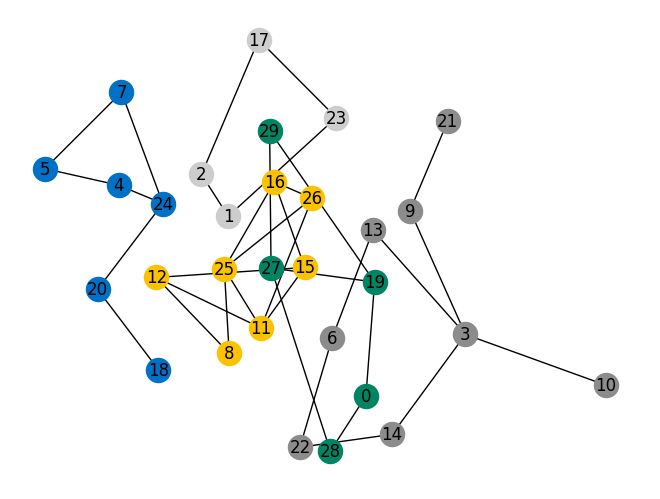

In [10]:
num_subgraphs = min(12, len(sampleGraph2.nodes())) # maximum number of subgraphs for the partition
subgraph_dictionary = subgraphPartition(sampleGraph2,num_subgraphs)

# Adding colors to visualize 7 or fewer subgraphs
blue = '#0071C5'
yellow = '#FAC200'
gray = '#8C8C8C'
emerald = '#008564'
light_gray = '#CDCDCD'
color_list = {}
# Define a multi-color mapping for 7 subgraphs or monochromatic mapping for 8 or more subgraphs
if len(subgraph_dictionary)<8:
    color_list = {"G0":gray, "G1": yellow, "G2": blue, "G3":emerald, "G4": light_gray, "G5": green, "G6":'white'}
else:
    for key in subgraph_dictionary:
        color_list[key] = {green}

# Print the subgraphs and their information
print('The parent graph is subdivided into',len(subgraph_dictionary),'subgraphs.')
for key in subgraph_dictionary:
    print('Graph',key,'has',len(nx.nodes(subgraph_dictionary[key])),'vertices.')
    print('The edges of',key,'are',nx.edges(subgraph_dictionary[key]))
    print('The nodes of',key,'are',nx.nodes(subgraph_dictionary[key]))
    nx.draw(subgraph_dictionary[key], with_labels=True, pos = pos, node_color = color_list[key])
plt.show()

Notice that each vertex of our original graph lies in exactly one subgraph of the partition defined by `subgraph_dictionary`. However, edges that connect vertices in distinct subgraphs in `subgraph_dictionary` are not drawn above.  For instance there is an edge between vertex $13$ and $15$ in `sampleGraph2` but, this edge does not appear in any of the subgraphs because the vertices $13$ and $15$ lie in separate subgraphs: `G0` and `G1`, respectively.  We'll consider edges like this later in this notebook, during the merger stage.

Throughout this notebook, it will be helpful to identify the subgraph that contains a given vertex. Let's define a function to do this.

In [11]:


def subgraph_of_vertex(graph_dictionary, vertex):
    """
    A function that takes as input a subgraph partition (in the form of a graph dictionary) and a vertex.
    The function should return the key associated with the subgraph that contains the given vertex.

    Parameters
    ----------
    graph_dictionary: dict of networkX.Graph with str as keys
    v : int
        v is a name for a vertex
    Returns
    -------
    str
        the key associated with the subgraph that contains the given vertex.
    """
    # in case a vertex does not appear in the graph_dictionary, return the empty string
    location = 'Vertex is not in the subgraph_dictionary'

    for key in graph_dictionary:
        if vertex in graph_dictionary[key].nodes():
            location = key
    return location


## 2.4 Conquer stage of the algorithm sequentially executed

In this section, we solve the max cut problem for each of the five subgraphs using QAOA. We first create a loop calling the `vqe`function to compute the optimal parameters for the QAOA algorithm and the `sample` function to find the optimal cut. Here, the `vqe` and `sample` functions are applied to each subgraph sequentially. In the section 2.6, we adapt the code to execute some of the computation in parallel.

Recall that in Lab 1, we learned how the `vqe` function and the `sample` primitive are used to implement QAOA and approximate the max cut of a graph.  Here, we iterate this on each of the subgraphs in the `subgraph_dictionary` to find the approximate max cut of each of the subgraphs.

Before we run this computation, let's first examine some of our options for circuit simulation. The code block below shows the backends available to us. We'll use the `qpp-cpu` which runs on a CPU. If you have access to a GPU, you can switch to the `nvidia` target, which provides a GPU-accelerated statevector simulator. By default the simulator uses `FP32` floating point types. To switch to `FP64`, you can reset the target to `nvidia-fp64`. Later in the lab, we'll experiment with some of the other targets which can leverage multi-node, multi-GPU simulators.

In [12]:
# Identify targets available to us
targets = cudaq.get_targets()
#for target in targets:
#    print(target)

# Set the target
cudaq.set_target("qpp-cpu")
#cudaq.set_target("nvidia")
target = cudaq.get_target()


Now that we've set the backend, we can find the approximate max cuts of the subgraphs using the functions that we defined in [Lab 1](1_Overview-Max-Cut-with-QAOA.ipynb).

** Exercise 2:** Edit the code block below replacing `FIX_ME` with the function from Lab 1 that solves the max cut problem using `vqe` and the `sample` commands.  For your reference, the functions from Lab 1 have been copied to the top of this notebook and reside in section 2.1.2. The names of these functions are:

* `hamiltonian_max_cut`
* `kernel_qaoa`
* `qaoa_for_graph`

If you haven't yet done so, scroll back up to section 2.1.2 and execute the cells in that section so that, when you have correctly completed the cell block below, it will run without error. It may take a minute or two for the computation to complete.

In [13]:
# Exercise 2

layer_count =1
results = {}
new_seed_for_each_graph = 0
shots = 25000
for key in subgraph_dictionary:
    G = subgraph_dictionary[key]
    results[key] = qaoa_for_graph(G, layer_count, shots, seed=653+new_seed_for_each_graph)
    new_seed_for_each_graph+=1
    print('The max cut QAOA coloring for the subgraph',key,'is',results[key])


Optimal parameters =  [0.3811067525772551, 2.752504235882645]
most_probable outcome =  01110100
The max cut QAOA coloring for the subgraph G0 is 01110100
Optimal parameters =  [0.2782533299549534, 1.2262600096652034]
most_probable outcome =  0011011
The max cut QAOA coloring for the subgraph G1 is 0011011
Optimal parameters =  [-1.1607166377338896, 1.178137855652034]
most_probable outcome =  010001
The max cut QAOA coloring for the subgraph G2 is 010001
Optimal parameters =  [-2.1238487740204635, -2.8970364567552265]
most_probable outcome =  01110
The max cut QAOA coloring for the subgraph G3 is 01110
Optimal parameters =  [-1.1780679446702005, -0.39274119724190604]
most_probable outcome =  1010
The max cut QAOA coloring for the subgraph G4 is 1010


Notice that in the previous exercise, the results for `G1` could not be computed until we finished finding the approximate max cut of `G0`. We could  speed up the process by carrying out the QAOA computations for each of the disjoint subgraphs in parallel. We'll explore options for parallelization later in this lab and in [Lab 3](3_Recursive-divide-and-conquer.ipynb).

## 2.5 Merge

One way to merge together the graph colorings from the subgraph max cut solutions is to take their union (since the subgraphs are all disjoint, this will result in a legal 2-coloring of the orginial graph).  However, this might not be optimal since there may be many edges between vertices in different subgraphs.  Nonetheless it is a good starting point and we can visualize this solution below.

### 2.5.1 First attempt at merging the subgraphs solutions together

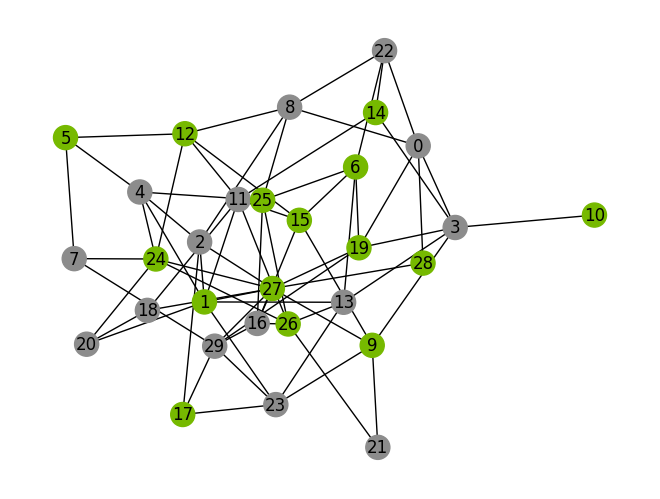

In [14]:
# Add color attribute to subgraphs and sampleGraph2 to record the subgraph solutions
# Plot sampleGraph2 with node colors inherited from the subgraph solutions

subgraphColors={}

for key in subgraph_dictionary:
    subgraphColors[key]=[int(i) for i in results[key]]


for key in subgraph_dictionary:
    G = subgraph_dictionary[key]
    for v in sorted(list(nx.nodes(G))):
        G.nodes[v]['color']=subgraphColors[key][sorted(list(nx.nodes(G))).index(v)]
        sampleGraph2.nodes[v]['color']=G.nodes[v]['color']

max_cut_color_map = [gray if sampleGraph2.nodes[u]['color']==0 else green for u in sampleGraph2]
pos = nx.spring_layout(sampleGraph2, seed=3113794652)  # set positions for all nodes

nx.draw(sampleGraph2, with_labels=True, pos = pos, node_color=max_cut_color_map)

plt.show()



Next let's compute the cut value of `sampleGraph2` given this coloring of the vertices. The cut will contain edges whose vertices have distinct colors.  We need to count all of the edges in the cut.

**Exercise 3:** Edit the code block below to compute the cut value, if we used the colors (0,1) of the nodes of `sampleGraph2` to define the cut.

In [15]:
# Exercise 3 Solution
union_cut_value = 0
union_cut_edges = []
for u, v in sampleGraph2.edges():
    if sampleGraph2.nodes[u]['color']   !=sampleGraph2.nodes[v]['color']   :
            union_cut_value+=1
            union_cut_edges.append((u,v))
print('The max cut value approximated from the subgraph colorings with no additional optimization is',union_cut_value)


The max cut value approximated from the subgraph colorings with no additional optimization is 43


The approximation of the max cut value of `sampleGraph2` that we just found isn't that close to the max cut value found through classical methods at the start of this lab. Since we'll be referring to this cut later, we'll give it a name: *unaltered cut*. We can improve the unaltered cut!

In the next section, we will attempt to alter the unaltered cut of `sampleGraph2` to find a cut with a higher cut value.   

Before we move to the next section, feel free to go back to the code block at the end of section 2.4 to experiment with different initial parameters by changing the random seeds. Did the max cut approximations improve? You can also explore what will happen if you increase the `layer_count` to 2, but only do this if you've got a several minutes to spare for the calculation to complete. If you're short on time, you can skip that experiment for now. There will be many more opportunities to experiment with `layer_count` throughout this series of labs.

### 2.5.2 Constructing a better global solution from the subgraph solutions through a brute-force method

Recall, that in [Lab 1](1_Overview-Max-Cut-with-QAOA.ipynb) we saw that by changing the colorings (i.e. changing the 0s to 1s and vice versa) of the nodes of one of the subgraphs, we might improve the merged solution. In the Lab 1 example, we only had 2 subgraphs.  Here we have many more subgraphs and can chose to flip the colors of all the vertices in some collection of the subgraphs. Let's see if changing one or more of the subgraph colors will improve our max cut estimate for `sampleGraph2`.

In [16]:
# Compute the cut value of the merged solutions from the subproblems
# Check all binary combinations (e.g. flipping all the colors for G0 and G1, flipping all colors from G0, etc)
# This actually can be done with another QAOA call instead of brute-force checking (as in arxiv:2205.11762)
# There are more sophisticated ways to construct a max cut approximation of the initial graph,
# which we will explore later in this tutorial.


# Create a list of all the subsets of the subgraphs
subsets = [[]]
for key in subgraph_dictionary:
    flipgraph = key
    for i in range(len(subsets)):
        subsets += [subsets[i]+[flipgraph]]


# Create a list of nodes to be flipped for each subset of subgraphs
flippedNodes ={}
for i in range(len(subsets)):
    flipgraphnodes=[]
    for key in subsets[i]:
        flipgraphnodes+=list(nx.nodes(subgraph_dictionary[key]))
    flippedNodes[i]=flipgraphnodes


# For each subset, compute the cut value if we flipped the colors
# of the nodes of the graphs in the subset
# Keep track of best cut value found so far
bestcut = 0
bestcutgraph = []
for i in range(len(subsets)):
    cut_from_subgraphs = 0
    cut_edges=[]
    for u,v in nx.edges(sampleGraph2):
        if u in flippedNodes[i]:
            coloru=1-sampleGraph2.nodes[u]['color']
        else:
            coloru = sampleGraph2.nodes[u]['color']
        if v in flippedNodes[i]:
            colorv=1-sampleGraph2.nodes[v]['color']
        else:
            colorv = sampleGraph2.nodes[v]['color']
        if coloru!=colorv:
            cut_from_subgraphs+=1
            cut_edges.append((u,v))
    if cut_from_subgraphs > bestcut:
        bestcutgraph=subsets[i]
        bestcut = cut_from_subgraphs

print('Max Cut approximation is the best when flipping nodes in',bestcutgraph)
print('and the cut value for this is',bestcut)


Max Cut approximation is the best when flipping nodes in ['G1', 'G3']
and the cut value for this is 51


Yay! We found a cut of the `sampleGraph2` whose cut value is closer to the classical approximation that we found at the beginning of this lab.  The down side, is that the brute-force procedure above scales terribly, requiring $2^h$ cycles through the loop in the code block above, where $h$ is the number of subgraphs in our partition. Fortunately, we can do better!

In the next section, we will consider the task above (of merging together subgraph solutions to find a good cut of the parent graph) as an optimization problem. We can use QAOA to solve this optimization problem.  

### 2.5.3 Constructing a better global solution from the subgraph solutions using QAOA

Recall at the end of [Lab 1](1_Overview-Max-Cut-with-QAOA.ipynb), we took the subgraph solutions and merged them together by flipping the colors of one of the subgraphs.  The graph on the left in the image below shows the unaltered cut from the subgraph solutions. The graph on the right depicts the new cut obtained from flipping the colors of the subgraph with vertices $\{0,1,2\}$. By flipping these colors, we were able to add the edge $(0,4)$ to the cut, while still maintaining the same number of cut edges in each of the two subgraphs.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/images/Lab1-results.png?raw=true)

The example from [Lab 1](1_Overview-Max-Cut-with-QAOA.ipynb) indicates that the edges connecting subgraphs influence the decision of which subgraph colorings should be flipped to find a coloring better than our unaltered cut value. In `sampleGraph2` we have multiple edges between the five different subgraphs. Changing the colors of one of the subgraphs to gain one edge, may remove other edges from the cut. We need a way to keep track of this.

To better understand this, let's isolate the important features in the analysis from [Lab 1](1_Overview-Max-Cut-with-QAOA.ipynb). We'll call the edges of `sampleGraph2` that don't appear in any subgraph (i.e., the edges that connect distinct subgraphs) *border edges* and we'll look at the subgraph of `sampleGraph2` generated by the border edges.  We'll call this subgraph `borderGraph.`  We can also visualize the edges in the borderGraph that would make the cut if we merged together the colorings from the subgraph solutions without making any changes. We will highlight the edges from `borderGraph` that are in the unaltered cut with the color green.

In [17]:
# First let's define a function that constructs the border graph

def border(G, subgraph_dictionary):
    """Build a graph made up of border vertices from the subgraph partition

    Parameters
    ----------
    G: networkX.Graph
        Graph whose max cut we want to find
    subgraph_dictionary: dict of networkX graph with str as keys
        Each graph in the dictionary should be a subgraph of G

    Returns
    -------
    networkX.Graph
        Subgraph of G made up of only the edges connecting subgraphs in the subgraph dictionary
    """
    borderG = nx.Graph()
    for u,v in G.edges():
        border = True
        for key in subgraph_dictionary:
            SubG = subgraph_dictionary[key]
            edges = list(nx.edges(SubG))
            if (u,v) in edges:
                border = False
        if border==True:
            borderG.add_edge(u,v)

    return borderG


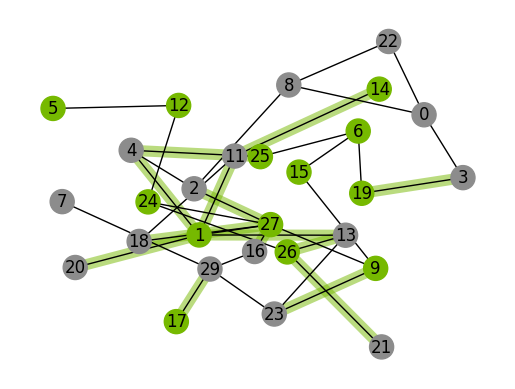

In [18]:
# Create the borderGraph
borderGraph = border(sampleGraph2, subgraph_dictionary)

for u in sampleGraph2.nodes():
    subgraph_id = subgraph_of_vertex(subgraph_dictionary, u)
    sampleGraph2.nodes[u]['subgraph_id']=subgraph_id

# identify the edges on the border that are in the unaltered cut
cut_edges_border = []
for u, v in borderGraph.edges():
    if sampleGraph2.nodes[u]['color'] != sampleGraph2.nodes[v]['color']:
        cut_edges_border+=[(u,v)]

# color the cut edges
max_cut_color_map = [gray if sampleGraph2.nodes[u]['color']==0 else green for u in borderGraph.nodes()]
# plot the border graph
nx.draw_networkx_edges(
    borderGraph,
    pos = pos,
    edgelist=cut_edges_border,
    width=8,
    alpha=0.5,
    edge_color=green,
)
nx.draw(borderGraph, pos = pos, node_color =max_cut_color_map, with_labels=True)
plt.show()



Our goal is to change the colors of the vertices in `borderGraph` by selecting a few of the subgraphs and changing all the colors of all nodes in those selected subgraphs from gray to green and green to gray. We want to swap colors in such a way that we can add as many of the edges of `borderGraph` into a cut of `sampleGraph2` as possible without sacrificing too many edges from the unaltered cut. Notice that if we swap all the colors of a subgraph, the total number of edges in the unaltered cut within that subgraph remains unchanged. Therefore, when changing the colors of a subgraph we only have to balance the gain of adding some of the (unhighlighted in the graph above) edges from the borderGraph into the cut with the cost of losing (highlighted green in the graph above) `borderGraph` edges from the unaltered cut.

This new optimization problem involves deciding whether or not to flip the colors of each subgraph. For each possible color change of subgraphs, we'll compute a "gain" from changing the colors. This gain is the number of border edges added to the cut from the alteration minus the number of border edges originally in the unaltered cut that are no longer in the cut after the color change. We want to maximize this gain.  In the following paragraph, we'll translate this to an optimization problem on a new graph: `mergerGraph`.

Since we have to decide whether or not to change the colors of a subgraph, we will have five variables, $s_0. s_1. s_2, s_3, s_4$, one for each subgraph.  We'll interpret $s_i=1$ as the decision not to flip the colors of subgraph `Gi`, and $s_i = -1$ to indicate that we will flip the colors of subgraph `Gi` when we merge the subgraph solutions together. We can refer to an assignment of values to the $s_i$ variables as a **swap schedule** since they determine which subgraphs will have their vertex colorings fixed and which subgraphs will have their vertex colorings swapped.

Finding an optimal swap schedule depends on the edges in the `borderGraph`. We can visualize this as a new graph, which we'll call the `mergerGraph`.  The vertices in this graph represent the subgraphs.  We'll label the nodes `G0`, `G1`, `G2`, `G3`, and `G4` to indicate their corresponding subgraph. Two nodes `Gi` and `Gj` in `mergerGraph` will be connected if there is at least one edge in `borderGraph` between a node in `Gi` and a node in `Gj`.  We're losing a bit of information (e.g. the number of edges between two subgraphs) through this definition, but we'll recover that information shortly, when we add a weight to the edges of this graph.  There is a lot going here! So, let's first take a look at the `mergerGraph` without weights.


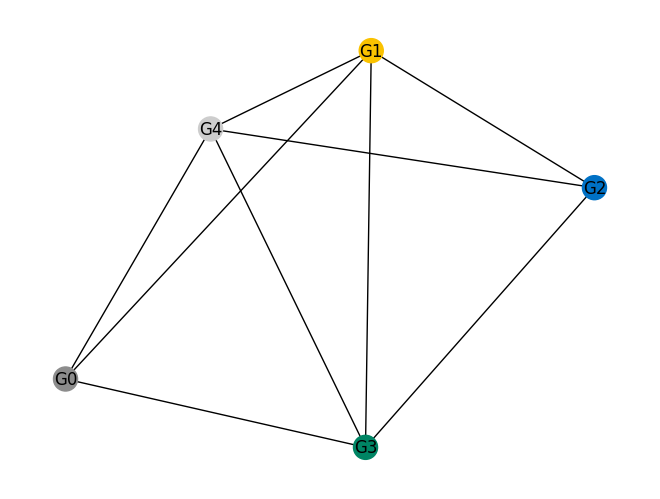

In [19]:
# Define the mergerGraph and color code the vertices
# according to the subgraph that the vertex represents
def createMergerGraph(border, subgraphs):
    """Build a graph containing a vertex for each subgraph
    and edges between vertices are added if there is an edge between
    the corresponding subgraphs

    Parameters
    ----------
    border: networkX.Graph
        Graph of connections between vertices in distinct subgraphs
    subgraphs: dict of networkX graph with str as keys
        The nodes of border should be a subset of the the graphs in the subgraphs dictionary

    Returns
    -------
    networkX.Graph
        Merger graph containing a vertex for each subgraph
        and edges between vertices are added if there is an edge between
        the corresponding subgraphs
    """

    H = nx.Graph()

    for u, v in border.edges():
        subgraph_id_for_u = subgraph_of_vertex(subgraphs, u)
        subgraph_id_for_v = subgraph_of_vertex(subgraphs, v)
        if subgraph_id_for_u != subgraph_id_for_v:
            H.add_edge(subgraph_id_for_u, subgraph_id_for_v)
    return H


mergerGraph = createMergerGraph(borderGraph, subgraph_dictionary)

pos_merger = nx.spring_layout(mergerGraph, seed=3221)
merger_color_map = [color_list[u] for u in mergerGraph.nodes()]
nx.draw(mergerGraph, with_labels=True, pos = pos_merger, node_color = merger_color_map)

plt.show()

Notice that there is no edge between node `G0` and node `G2` in the `mergerGraph` because in `sampleGraph2`, no vertex in `G0` shares an edge with any vertex in `G2`.  

Since we're collapsing all the vertices in a subgraph down to just one vertex in `mergerGraph`, we lose information about the number of edges between subgraphs.  More importantly we lose information about the number of edges between subgraphs that are in the unaltered cut and the number of edges that are not in that cut. This information is important in deciding whether or not to change the colors of the vertices in one of the subgraphs.  We'll record this information as penalities of edges between the nodes in `mergerGraph`.  For every edge in `borderGraph` connecting subgraph `Gi` to `Gj`, we'll add 1 to the `penalty` of the edge `(Gi,Gj)` in `mergerGraph`if the edge was in the unaltered cut and we'll subtract 1 from the `penalty` if the edge was not in the unaltered cut. The idea being that if we flip the colors of subgraph `Gi` we may lose some edges and gain others in the new cut. A positive penalty would indicate that there are more edges between subgraphs `Gi` and `Gj` that would be removed from the cut than gained when we swap the colors of one of the subgraphs. So a negative penalty between vertices can be thought of as a gain of edges in the cut from flipping one of the subgraph colorings.  

Before we compute the penalties for each edge in `mergerGraph`, let's just consider the nodes `G1` and `G2`.  We've plotted both of these graphs below with `G1` in yellow and `G2` in blue with the edges between the subgraphs highlighted in gray and green. The edges colored green are in the unaltered cut. There are $5$ edges connecting a vertex in `G1` with one in `G2`: $(5,12)$, $(24, 12)$, $(4,25)$, $(24, 26)$, and $(18,11)$.  Notice that one of these edges is colored green (and hence in unaltered cut) and the other 4 are not.  This means that if were to alter the coloring that determined the unaltered cut by flipping the colors of either the nodes in `G1` or the nodes in `G2` we would lose one edge (the green one) but gain four edges in the new modified cut.  The penalty for changing the color of one of these two subgraphs would be $1-4 =-3$ (i.e., we would have a net gain of $3$ edges).

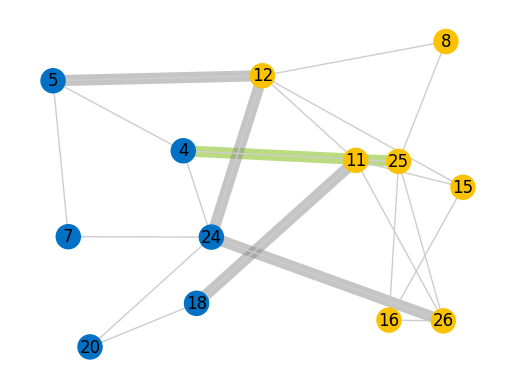

In [20]:
# Focusing in on just 2 subgraphs to illustrate the penalty computation
keys_to_focus = ['G1','G2']
nodes_in_G1_and_G2 = []
for key in keys_to_focus:
    for u in nx.nodes(subgraph_dictionary[key]):
        nodes_in_G1_and_G2.append(u)

focusGraph = nx.subgraph(sampleGraph2,nodes_in_G1_and_G2)

cut_edges_focus = []
uncut_edges_focus = []
for (u,v) in focusGraph.edges():
    if subgraph_of_vertex(subgraph_dictionary, u)!= subgraph_of_vertex(subgraph_dictionary,v):
        if sampleGraph2.nodes[u]['color'] != sampleGraph2.nodes[v]['color']:
            cut_edges_focus+=[(u,v)]
        else:
            uncut_edges_focus+=[(u,v)]


focus_color_map = [color_list[subgraph_of_vertex(subgraph_dictionary, u)] for u in focusGraph.nodes()]
nx.draw_networkx_edges(
    focusGraph,
    pos = pos,
    edgelist=cut_edges_focus,
    width=8,
    alpha=0.5,
    edge_color=green,
)
nx.draw_networkx_edges(
    focusGraph,
    pos = pos,
    edgelist=uncut_edges_focus,
    width=8,
    alpha=0.5,
    edge_color=gray,
)
nx.draw(focusGraph, with_labels=True, pos = pos, node_color = focus_color_map, edge_color = light_gray)


Continuing to focus on subgraphs `G1` and `G2`, let's combine the penalty (which we'll denote $p_{1,2}$) term together with the variables $s_1$ and $s_2$ by considering the product $p_{1,2}s_1s_2$.  If we assigned $s_1 = -1$ and $s_2 = 1$, then this product &mdash; which we can think of as the gain &mdash; would be $(-3)(-1)(1)=3$. We can interpret this as a gain of $3$ edges if we swap colors of `G1` but kept the colors of the nodes in `G2` fixed. On the other hand, if we didn't change the colors of either subgraph, or if we changed the colors of both subgraphs, then the product $p_{1,2}s_1s_2$ would be negative, indicating we'd be worse off.

This allows us to frame the merger process as a minimization problem, and we'll be able to use QAOA to solve it. Thinking of just the subgraphs `G1` and `G2`, we would want to maximize the gain $p_{1,2}s_1s_2$; in other words we need to
minimize the product $-1*p_{1,2}s_1s_2$. Therefore, our optimization problem is to minimize the penalties of all edges in `mergerGraph`. This means we will want to minimize the function:
$$P(\bar s) = -\sum_{u,v\in E_m}p_{uv}s_us_v,$$
where $E_m$ is the set of edges in the `mergerGraph`.

Now that we know what we need to minimize, let's compute the penalties for all edges in `mergerGraph`.

**Exercise 4:** Edit the code block below in the two `FIX_ME` locations.  Hint: you'll either be adding 1 or subtracting 1 from the running computation of the penalty (`penalty_ij`) between node `Gi` and `Gj`.

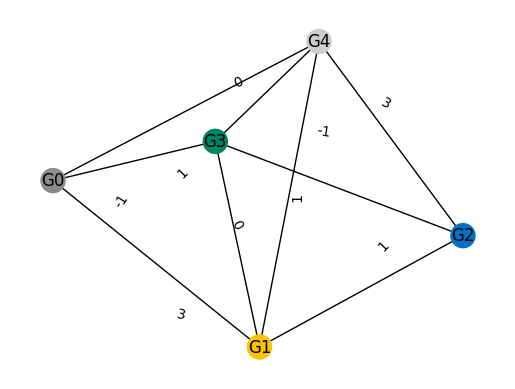

In [28]:
# Exercise 4
# Add attribute to capture the penalties of changing subgraph colors

# Initialize all the penalties to 0
nx.set_edge_attributes(mergerGraph, int(0), 'penalty')

# Compute penalties for each edge
for i, j in mergerGraph.edges():
   penalty_ij = 0
   for u in subgraph_dictionary[i]:
      for neighbor_u in nx.all_neighbors(sampleGraph2, u):
         if neighbor_u in subgraph_dictionary[j]:
            if sampleGraph2.nodes[u]['color'] != sampleGraph2.nodes[neighbor_u]['color']:
               penalty_ij += -1
            else:
               penalty_ij += 1
   mergerGraph[i][j]['penalty'] = penalty_ij


# Graph the penalties of each edge
edge_labels = nx.get_edge_attributes(mergerGraph, 'penalty')
nx.draw_networkx_edge_labels(mergerGraph,  edge_labels=edge_labels,  pos=pos_merger)
nx.draw(mergerGraph, node_color = merger_color_map, with_labels=True)
plt.show()


Now that we have penalties assigned, our aim is to find an assignment of the variables $s_i$ so that $P(\bar s)$ is minimized.  Very similarly to how we derived the Max Cut Hamiltonian in section 1.5 of [Lab 1](1_Overview-Max-Cut-with-QAOA.ipynb), we can define a Hamiltonian fpr $P(\bar s)$ which we'll refer to as the `mergerHamiltonian`. This is done by replacing every instance of $s_i$ in $P$ with a Pauli-$Z$ operator applied to the qubit associated with $i$.  We'll be reusing this in Lab 3, so let's write a function to create the `mergerHamiltonian`.

In [29]:
# Define the Hamiltonian for applying QAOA to the variables
# s_i where s_i = 1 means we will not flip the subgraph Gi's colors
# and s_i = -1 means we will flip the colors of subgraph G_i

def mHamiltonian(merger):
    """Hamiltonian for finding the optimal swap schedule for the subgraph partitioning encoded in the merger graph

    Parameters
    ----------
    merger: networkX.Graph
        Weighted graph

    Returns
    -------
    cudaq.SpinOperator
        Hamiltonian for finding the optimal swap schedule for the subgraph partitioning encoded in the merger graph
    """

    mergerHamiltonian = 0
    mergerNodes = sorted(list(merger.nodes()))
 # Add Hamiltonian terms for edges within a subgraph that contain a border element
    for u, v in merger.edges():
        qubitu = mergerNodes.index(u)
        qubitv = mergerNodes.index(v)
        mergerHamiltonian+= -1*merger[u][v]['penalty']*(spin.z(qubitu))*(spin.z(qubitv))
    return mergerHamiltonian


We're now ready to apply QAOA to find a solution to the merger problem (i.e. find values for $s_i$ so that $P(\bar s)$ is minimized).  This is very similar to what we did in [Lab 1](1_Overview-Max-Cut-with-QAOA.ipynb) to find the minimum of the Max Cut Hamiltonian.

**Exercise 5:** Edit the code block below, changing the `FIX_ME` functions to a selection from the following.  Two of these options will not be used.
* `cudaq.sample`   
* `cudaq.observe`
* `cudaq.vqe`
* `.expectation()`
* `.most_probable()`



In [31]:
# Exercise 5 
# Run QAOA on the merger subgraph to identify which subgraphs
# if any should change colors

layer_count_merger = 1 # set arbitrarily
parameter_count_merger: int = 2 * layer_count_merger

# Specify the optimizer and its initial parameters. Make it repeatable.
cudaq.set_random_seed(101)
optimizer_merger = cudaq.optimizers.COBYLA()
np.random.seed(101)
optimizer_merger.initial_parameters = np.random.uniform(-np.pi, np.pi,
                                                     parameter_count_merger)
optimizer_merger.max_iterations=150

merger_nodes = list(mergerGraph.nodes())
qubit_count = len(merger_nodes)
merger_edge_src = []
merger_edge_tgt = []
for u, v in nx.edges(mergerGraph):
    # We can use the index() command to read out the qubits associated with the vertex u and v.
    merger_edge_src.append(merger_nodes.index(u))
    merger_edge_tgt.append(merger_nodes.index(v))

# Pass the kernel, spin operator, and optimizer to `cudaq.vqe`.
optimal_expectation, optimal_parameters = cudaq.vqe(
    kernel=kernel_qaoa,
    spin_operator=mHamiltonian(mergerGraph),
    argument_mapper=lambda parameter_vector: (qubit_count, layer_count, merger_edge_src, merger_edge_tgt, parameter_vector),
    optimizer=optimizer_merger,
    parameter_count=parameter_count_merger,
    shots = 10000)

# Print the optimized value and its parameters
print("Optimal value = ", optimal_expectation)
print("Optimal parameters = ", optimal_parameters)

# Sample the circuit using the optimized parameters
sample_number=15000
counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, merger_edge_src, merger_edge_tgt, optimal_parameters, shots_count=shots)
print(f"most_probable = {counts.most_probable()}")

# Merger results
mergerResultsString=counts.most_probable()

Optimal value =  -4.082999999999999
Optimal parameters =  [0.7861268338562293, 2.381963647916859]
most_probable = 10110


To interpret the results, notice that a result such as `most_probable = 10110` would indicate that we can improve the unaltered cut by flipping the colors of the vertices in subgraphs `G0`, `G2`, and `G3`. Let's see how the new coloring determined by the results of the previous cell affects our max cut value of the `sampleGraph2`.

In [ ]:
# Record a new coloring of the sampleGraph2 according to the merger results
# with a node vertex attribute 'new_color'
flipGraphColors={}

mergerNodes = sorted(list(nx.nodes(mergerGraph)))
for u in mergerNodes:
    indexu = mergerNodes.index(u)
    flipGraphColors[u]=int(mergerResultsString[indexu])


for key in subgraph_dictionary:
    if flipGraphColors[key]==1:
        for u in subgraph_dictionary[key].nodes():
            sampleGraph2.nodes[u]['new_color'] = 1 - sampleGraph2.nodes[u]['color']
    else:
        for u in subgraph_dictionary[key].nodes():
             sampleGraph2.nodes[u]['new_color'] = sampleGraph2.nodes[u]['color']

# Compute the new cut of the larger graph based on the new colors
max_cut = 0
max_cut_edges = []
for u, v in sampleGraph2.edges():
    if sampleGraph2.nodes[u]['new_color'] != sampleGraph2.nodes[v]['new_color']:
            max_cut+=1
            max_cut_edges.append((u,v))
print('The max cut value approximated from the Divide and Conquer QAOA is',max_cut)



Yay!  We've found a better cut of `sampleGraph2`than the unaltered cut! Feel free to experiment with higher layer counts and different seeds to see if you can achieve an even better approximation.


## 2.6 Enabling Distributed Quantum Computing

You may have noticed that it took a little bit of time to find the max cut approximation in the previous section.  Here we'll investigate one way of speeding this up.

A programmer may have available one or many host CPUs, zero or many NVIDIA GPUs, and zero or many QPUs (see image below). CUDA-Q allows for easy porting between classical computers, simulated QPUs, and real QPUs. Additionally CUDA-Q provides many opportunities for parallelization of quantum circuit simulation and execution.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/images/architecture.png?raw=true)

In the near-term, it is unlikely that the underlying platform may expose multiple QPUs. However, the availability of GPU-based circuit simulators on NVIDIA multi-GPU architectures does provide an opportunity to think about programming such a multi-QPU architecture now, and CUDA-Q's seamless transition from simulation to physical QPUs accommodates the changing quantum ecosystem.
In this lab, we'll demonstrate how to execute the QAOA circuits for each subgraph simultaneously on multiple GPU processes using MPI, and we will demonstrate how this can be adapted to run on multiple QPUs when available.

**Important:** Before proceeding, you will need to switch to a runtime with access to a GPU.  To switch to a GPU instance on qBraid Lab, use the [Compute Manager](https://docs.qbraid.com/lab/user-guide/compute-manager) to select a GPU-enabled instance and run your notebooks within the CUDA-Q environment. 

In [ ]:
#@title Execute this cell to reload the necessary packages
import networkx as nx
from networkx import algorithms
from networkx.algorithms import community
import cudaq
from cudaq import spin
from cudaq.qis import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import sys

In [ ]:
#@title Execute this cell to install mpi4py if necessary
%pip install mpi4py

Let's run the cell below to verify that we have CUDA-Q set up to run on GPUs.  It will print out the number of GPUs available. The NVIDIA multiple-QPU option of the target (`nvidia`) provides a simulated QPU for every available NVIDIA GPU on the underlying system.

In [ ]:
cudaq.set_target("nvidia", option="mqpu")
target = cudaq.get_target()
num_qpus = target.num_qpus()
print("Number of GPUs:", num_qpus)

Instead of using one GPU to simulate one QPU, because our quantum kernel doesn't contain too many qubits, we can actually run several processes on our GPU in parallel, with each process simulating a QPU. We can simulate multiple QPUs on one machine by executing a python script using Message Passing Interface (MPI). Each QPU is simulated via a `cuStateVec` simulator backend and the `nvidia` target.


Let's create a python script to send max cut approximation tasks for each subgraph to separate processes on the available GPU(s). We will then execute this script with MPI.  MPI is a parallel programming communication protocol. For this lab, it's enough to understand that MPI assigns names (referred to as ranks) to each of the available processes on the available GPUs. When we use the `mpiexec` command, the script that we create is executed on all of the GPUs.  To differentiate what gets computed on each of the GPUs we use the `rank` variable.

For this lab, if you have 1 available GPU, you can distribute 4 separate processes on this GPU to run in parallel.  We'll use the processor with rank 0 as our home base. This is where all of the graph data will be stored and we'll use this processor for computation too. Our script will carry out the following steps:
* **Step1:** The GPU process with rank 0 will carry out the divide stage of the divide-and-conquer QAOA.  In particular, it will generate the `sampleGraph2` and all its subgraphs.  This QPU will assign subgraph problems to all of the GPU processes (including itself). It will then distribute the relevant subgraph data to the other GPU processes.  
* **Step 2:** Each GPU process will find the approximate max cuts of the graphs that it was assigned, and then communicate those solutions back to the GPU process with rank 0.  
* **Step 3:** The GPU process with rank 0 will merge together all of the subgraph solutions to complete the merge stage of the divide-and-conquer algorithm.

### Step 1
Our script will have an `if rank==0:` and `else:` structure to separate out the tasks that the GPU process with rank 0 will do differently from the other GPU processes.  For the GPU process with rank 0, we'll copy over all the code that we've written earlier in this lab to create the `sampleGraph2` and subdivide it into subgraphs stored in `subgraph_dictionary`.  Next, we need to decide GPU-process assignments for the subgraphs.  We won't worry about doing this optimally in this tutorial.  For now, we simply need to map each subgraph to a GPU process.  Since we have 5 subgraphs and 4 GPU processes available (remember we're using GPU with rank 0 for computation too), one of the GPU processes will be tasked with solving max cut problems for two subgraphs.

**Exercise 6:** Edit the code block below to define a dictionary `keys_on_qpu` that maps GPU ranks to subsets of subgraph names.  For instance one mapping might be `{0:['G0','G4'], 1:['G1'], 2:['G2'], 3:['G3']}`

In [ ]:
# Exercise 6
# Assign the subgraphs to the QPUs
num_qpus = 4
number_of_subgraphs = len(sorted(subgraph_dictionary))
number_of_subgraphs_per_qpu = int(np.ceil(number_of_subgraphs/num_qpus))

keys_on_qpu ={}

for q in range(num_qpus):
    keys_on_qpu[q]=[]
    for k in range(number_of_subgraphs_per_qpu):
        ### Add code below this line


        ### Add code above this line
    print(keys_on_qpu[q],'=subgraph problems to be computed on processor',q)


Take a look at the [Example-02-step-1.py](Example-02-step-1.py) file to see how the GPU process with `rank` 0 carries out the subgraph division and communicates the relevant subgraph data to the remaining GPU processes. The variable `assigned_subgraph_dictionary` (whose definition depends on the `rank` variable) is introduced to hold only the portion of the `subgraph_dictionary` that is needed by the GPU associated with the value of `rank`.

Run the following cell to use MPI to execute this step and watch the output that reflects the actions that have been completed by the different processors.

In [ ]:
# MPI call
print(sys.executable)
python_path = sys.executable
!mpiexec -np 4 {python_path} Example-02-step-1.py

### Step 2
Now let's turn our attention to Step 2 of the parallelization. For this step, we need to add to the [Example-02-step-1.py](Example-02-step-1.py) script instructions so that each of the GPUs will solve the max cut problems for the subgraphs assigned to it. We'll need to copy over all of the necessary functions that we've defined so far (e.g., `vqe_optimize`, `vqe_sample`, `hamiltonian_max_cut`, `kernel_qaoa`) replacing all of the `subgraph_dictionary` instances with `assigned_subgraph_dictionary`.  We've done this step for you and save the work in the [Example-02-step-2.py](Example-02-step-2.py) file

In [ ]:
# MPI call
!mpiexec -np 4 {python_path} Example-02-step-2.py

As you run the [Example-02-step-2.py](Example-02-step-2.py) file with MPI, you might notice that there is some overhead in subdividing the graph and communicating that information to the GPUs. However, once the subgraph data is loaded onto the GPU processes, the max cut computations are carried out rather quickly.

Another thing to notice is that the max cut results for each of the subgraphs currently reside on the individual GPU processes, and we'll need to communicate that information back to the GPU process with rank 0 so that they can be merged together to get a cut of the entire `sampleGraph2`.  Let's see what is needed to carry out this communication.

**Exercise 7:** Carry out the following steps to move the subgraph solutions ot the first GPU and verify the action.
1. Complete the code block below  
2. Copy over the completed code block to the bottom of the Example-02-step-2.py file
3. Save the file as Example-02-step-2-Solution.py  
4. Execute the revised script with MPI to verify that the max cut solutions of the subgraphs all now reside on the GPU process with rank 0.

In [ ]:
# Note that this cell block will generate an error message when executed in the Jupyter notebook.
# You will need to copy the code over to the Example-02-step-2.py file and 
# save the result as Example-02-step-2-Solution.py

# Let's introduce another MPI function that will be useful to
# iterate over all the GPUs.
size = comm.Get_size()

# Copy the results over to QPU 0 for consolidation
if rank!=0:
    comm.send(results, dest=FIX_ME, tag=0)
    print("{} sent by processor {}".format(results, rank))
else:
    for j in range(1,size,1):
        colors = comm.recv(source=FIX_ME, tag=0)
        print("Received {} from processor {}".format(colors, j))
        for key in colors:
            results[key]=colors[key]
    print("The results dictionary on GPU 0 =", results)


In [ ]:
# MPI call
!mpiexec -np 4 {python_path} Example-02-step-2-Solution.py

Yay!  We have managed to create a parallel version of the conquer stage of the divide-and-conquer QAOA.  

### Step 3
All that is left is to merge together the subgraph solutions in an optimal way. We've added the necessary functions and tasks to the [Example-02-step-3-Solution.py](Example-02-step-3-Solution.py) to complete this step.

In [ ]:
# MPI call
!mpiexec -np 4 {python_path} Example-02-step-3-Solution.py

You may have noticed that the max cut approximation that was returned from the [Example-02-step-3-Solution.py](Example-02-step-3-Solution.py) script is different from the one that we computed earlier in this lab.  This is because our random seeds in the python script were different than the ones in this notebook. Before moving on to the next lab, we encourage you to change some of the random seeds throughout the notebook to see that the divide-and-conquer QAOA applied to the same graph will give different results depending on the initial parameters. Moreover, sometimes the initial parameters that are randomly selected lead to a [barren plateau](https://quantum-journal.org/papers/q-2021-10-05-558/pdf/) and an NL Opt error breaks the execution. Increasing the number of shots or changing the maximum number of iterations of the optimizer may remedy this.

Another variable to experiment with is the `layer_count`.  Increasing the `layer_count` generally leads to better solutions.  However, this comes at the expense of increased circuit depth which may increase the runtime of the simulation (at best) or may prohibit the simulation from completing.

You can also experiment with changing the parameters (number of edges and number of vertices) that generated our random graph to get a sense of the limitations of the divide-and-conquer algorithm (as it is currently written in this notebook).  In particular, random graphs with 100 nodes may generate subgraphs that are too large for the QAOA algorithm.  Additionally, some conquer graphs may produce trivial QAOA instances where the the `mergerHamiltonian` is null.  We'll take care of those problems in the next lab.

Looking towards the future when multiple QPUs are available, the [remote QPU `nvidia-mqpu` platform](https://nvidia.github.io/cuda-quantum/latest/using/backends/platform.html#mqpu-platform) could be leveraged to run this QAOA algorithm in parallel on multiple QPUs.

## Next




The graph in this notebook was small enough that the divide stage produced only a few subgraphs, each of which was sufficiently small to easily identify the max cut using QAOA. Proceed to [Lab 3](3_Recursive-divide-and-conquer.ipynb) where we'll tackle larger graphs!

